In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
from datetime import datetime
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, GRU
from keras.layers import *
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping
from keras.optimizers import Adam, SGD

In [6]:
df = pd.read_csv("BTC-USD.csv")
df = df.sort_values('Date').reset_index(drop=True)
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2014-09-17,465.864014,468.174011,452.421997,457.334015,457.334015,21056800
1,2014-09-18,456.859985,456.859985,413.104004,424.440002,424.440002,34483200
2,2014-09-19,424.102997,427.834991,384.532013,394.795990,394.795990,37919700
3,2014-09-20,394.673004,423.295990,389.882996,408.903992,408.903992,36863600
4,2014-09-21,408.084991,412.425995,393.181000,398.821014,398.821014,26580100


In [7]:
df.shape

(2713, 7)

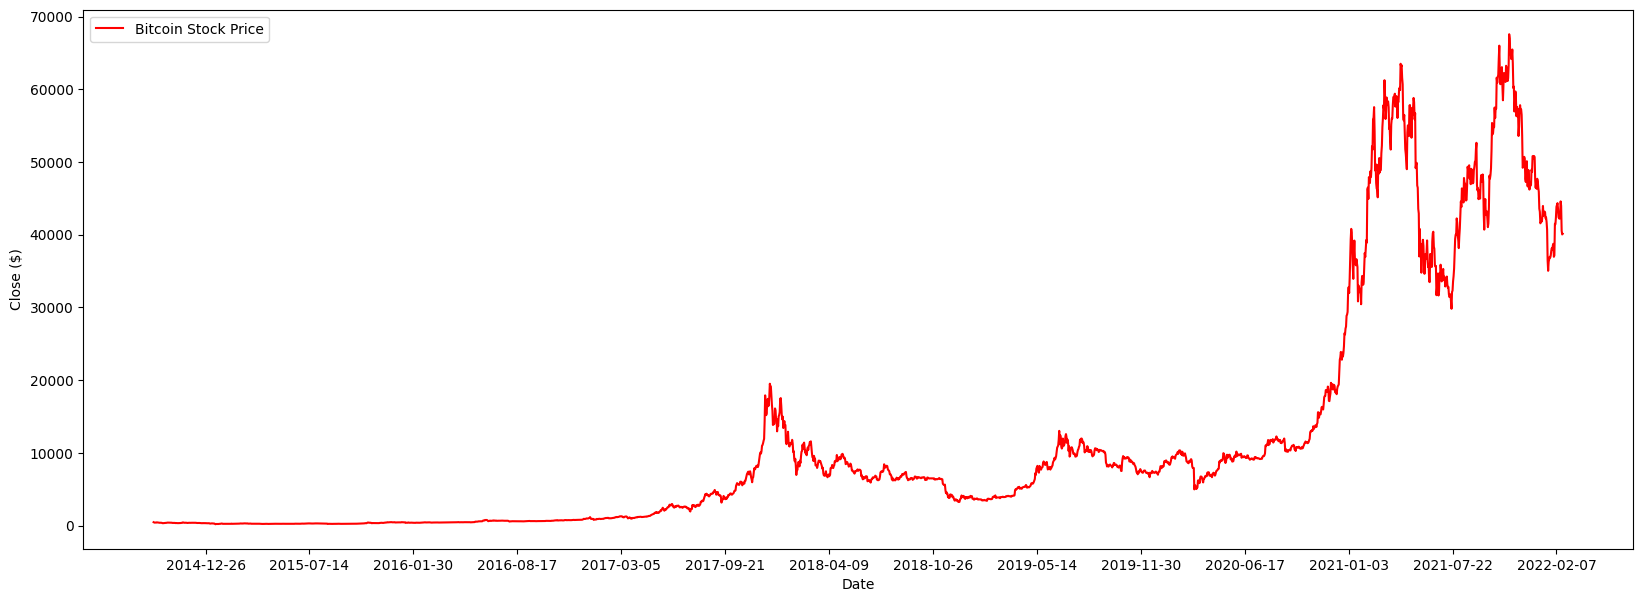

In [8]:
df['Close'] = df['Close'].astype(float)

plt.figure(figsize=(20,7))
plt.plot(df['Date'].values, df['Close'].values, label = 'Bitcoin Stock Price', color = 'red')
plt.xticks(np.arange(100,df.shape[0],200))
plt.xlabel('Date')
plt.ylabel('Close ($)')
plt.legend()
plt.show()

In [12]:
num_shape = 2000

train = df.iloc[:num_shape, 1:2].values
test = df.iloc[num_shape:, 1:2].values
print ("train ",train.shape)
print ("test",test.shape)

train  (2000, 1)
test (713, 1)


In [14]:
sc = MinMaxScaler(feature_range = (0, 1))
train_scaled = sc.fit_transform(train)
train_scaled

array([[0.01497323],
       [0.01450668],
       [0.01280933],
       ...,
       [0.46123923],
       [0.46348247],
       [0.45242513]])

In [19]:
X_train = []

#Price on next day
y_train = []

window = 60

for i in range(window, num_shape):
    X_train_ = np.reshape(train_scaled[i-window:i, 0], (window, 1))
    X_train.append(X_train_)
    y_train.append(train_scaled[i, 0])
X_train = np.stack(X_train)
y_train = np.stack(y_train)

print ("X_train", X_train.shape)
print ("y_train", y_train.shape)

X_train (1940, 60, 1)
y_train (1940,)


In [20]:
# Initializing the Recurrent Neural Network
model = Sequential()
#Adding the first LSTM layer with a sigmoid activation function and some Dropout regularization
#Units - dimensionality of the output space

model.add(LSTM(units = 50, return_sequences = True, input_shape = (X_train.shape[1], 1)))
model.add(Dropout(0.2))

model.add(LSTM(units = 50, return_sequences = True))
model.add(Dropout(0.2))

model.add(LSTM(units = 50, return_sequences = True))
model.add(Dropout(0.2))

model.add(LSTM(units = 50))
model.add(Dropout(0.2))

# Adding the output layer
model.add(Dense(units = 1))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 60, 50)            10400     
                                                                 
 dropout (Dropout)           (None, 60, 50)            0         
                                                                 
 lstm_1 (LSTM)               (None, 60, 50)            20200     
                                                                 
 dropout_1 (Dropout)         (None, 60, 50)            0         
                                                                 
 lstm_2 (LSTM)               (None, 60, 50)            20200     
                                                                 
 dropout_2 (Dropout)         (None, 60, 50)            0         
                                                                 
 lstm_3 (LSTM)               (None, 50)                2

In [21]:
model.compile(optimizer = 'adam', loss = 'mean_squared_error')
model.fit(X_train, y_train, epochs = 100, batch_size = 128);

Epoch 1/100
16/16 [==============================] - 23s 433ms/step - loss: 0.0229
Epoch 2/100
16/16 [==============================] - 7s 423ms/step - loss: 0.0053
Epoch 3/100
16/16 [==============================] - 7s 405ms/step - loss: 0.0041
Epoch 4/100
16/16 [==============================] - 7s 414ms/step - loss: 0.0034
Epoch 5/100
16/16 [==============================] - 7s 449ms/step - loss: 0.0033
Epoch 6/100
16/16 [==============================] - 6s 397ms/step - loss: 0.0028
Epoch 7/100
16/16 [==============================] - 6s 387ms/step - loss: 0.0029
Epoch 8/100
16/16 [==============================] - 6s 389ms/step - loss: 0.0028
Epoch 9/100
16/16 [==============================] - 7s 401ms/step - loss: 0.0024
Epoch 10/100
16/16 [==============================] - 6s 402ms/step - loss: 0.0023
Epoch 11/100
16/16 [==============================] - 6s 401ms/step - loss: 0.0022
Epoch 12/100
16/16 [==============================] - 6s 394ms/step - loss: 0.0020
Epoch 13/100

In [25]:
df_volume = np.vstack((train, test))

inputs = df_volume[df_volume.shape[0] - test.shape[0] - window:]
inputs = inputs.reshape(-1,1)
inputs = sc.transform(inputs)

num_2 = df_volume.shape[0] - num_shape + window

X_test = []

for i in range(window, num_2):
    X_test_ = np.reshape(inputs[i-window:i, 0], (window, 1))
    X_test.append(X_test_)
    
X_test = np.stack(X_test)

print ("input", inputs.shape)
print ("num_2", num_2)
print ("x_test" , X_test.shape)

input (773, 1)
num_2 773
x_test (713, 60, 1)


In [26]:
predict = model.predict(X_test)
predict = sc.inverse_transform(predict)

23/23 [==============================] - 5s 61ms/step


In [32]:
diff = predict - test

print("MSE:", np.mean(diff**2))
print("MAE:", np.mean(abs(diff)))
print("RMSE:", np.sqrt(np.mean(diff**2)))


MSE: 91351424.04793324
MAE: 7044.559930617242
RMSE: 9557.793890220339


In [30]:
def MAPE(Y_actual,Y_Predicted):
    mape = np.mean(np.abs((Y_actual - Y_Predicted)/Y_actual))*100
    return mape


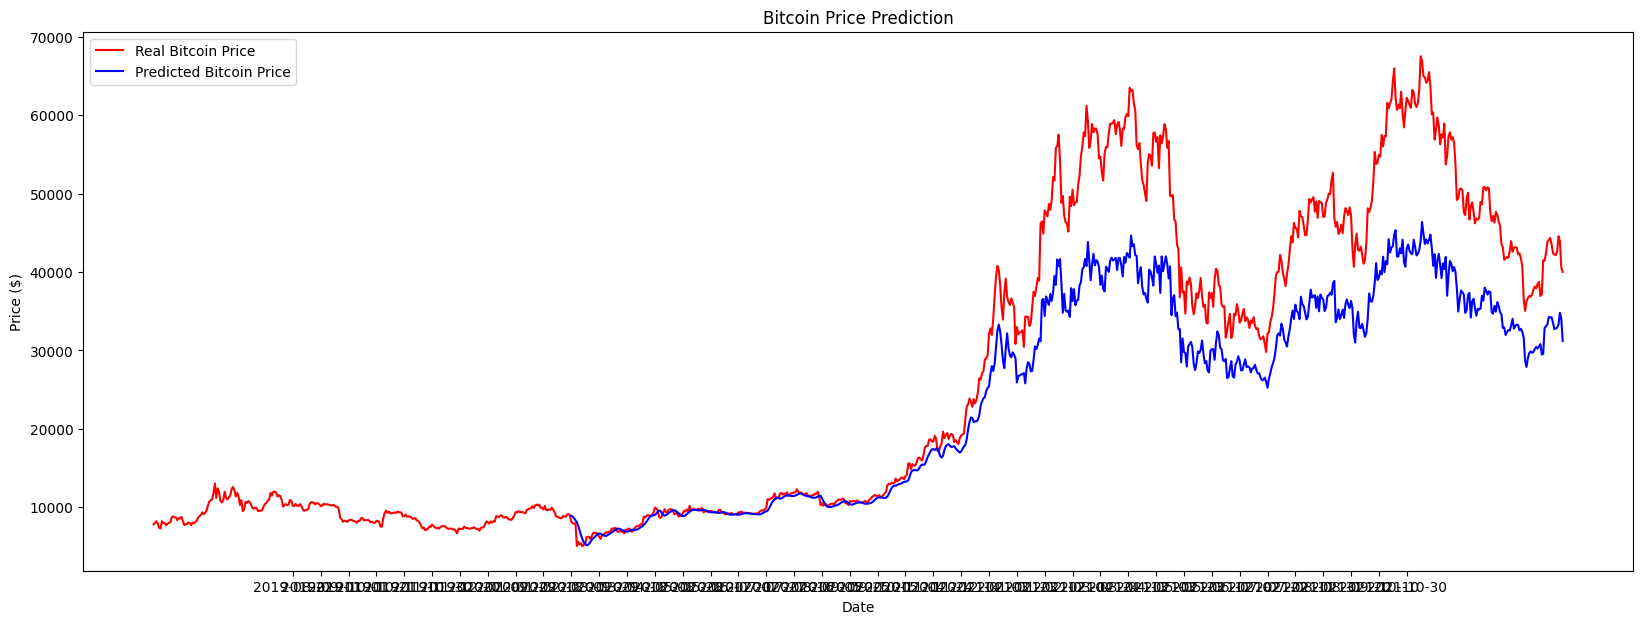

In [33]:
plt.figure(figsize=(20,7))
plt.plot(df['Date'].values[1700:], df_volume[1700:], color = 'red', label = 'Real Bitcoin Price')
plt.plot(df['Date'][-predict.shape[0]:].values, predict, color = 'blue', label = 'Predicted Bitcoin Price')
plt.xticks(np.arange(100,df[1800:].shape[0],20))
plt.title('Bitcoin Price Prediction')
plt.xlabel('Date')
plt.ylabel('Price ($)')
plt.legend()
plt.show()

In [34]:
pred_ = predict[-1].copy()
prediction_full = []
window = 60
df_copy = df.iloc[:, 1:2][1:].values

for j in range(10):
    df_ = np.vstack((df_copy, pred_))
    train_ = df_[:num_shape]
    test_ = df_[num_shape:]
    
    df_volume_ = np.vstack((train_, test_))

    inputs_ = df_volume_[df_volume_.shape[0] - test_.shape[0] - window:]
    inputs_ = inputs_.reshape(-1,1)
    inputs_ = sc.transform(inputs_)

    X_test_2 = []

    for k in range(window, num_2):
        X_test_3 = np.reshape(inputs_[k-window:k, 0], (window, 1))
        X_test_2.append(X_test_3)

    X_test_ = np.stack(X_test_2)
    predict_ = model.predict(X_test_)
    pred_ = sc.inverse_transform(predict_)
    prediction_full.append(pred_[-1][0])
    df_copy = df_[j:]

23/23 [==============================] - 1s 55ms/step


In [36]:
prediction_full_new = np.vstack((predict, np.array(prediction_full).reshape(-1,1)))
prediction_full_new

array([[ 8883.663 ],
       [ 8797.192 ],
       [ 8571.482 ],
       [ 8302.407 ],
       [ 8069.2354],
       [ 7587.968 ],
       [ 6987.9727],
       [ 6387.418 ],
       [ 5890.386 ],
       [ 5509.9497],
       [ 5260.0854],
       [ 5131.249 ],
       [ 5176.377 ],
       [ 5374.0215],
       [ 5644.722 ],
       [ 5868.664 ],
       [ 6053.287 ],
       [ 6236.407 ],
       [ 6407.5303],
       [ 6549.41  ],
       [ 6622.6333],
       [ 6605.882 ],
       [ 6494.7153],
       [ 6384.087 ],
       [ 6322.4536],
       [ 6331.5356],
       [ 6413.7817],
       [ 6530.8423],
       [ 6657.096 ],
       [ 6760.3486],
       [ 6880.3223],
       [ 7004.616 ],
       [ 7128.3955],
       [ 7231.9043],
       [ 7252.515 ],
       [ 7195.8984],
       [ 7113.2915],
       [ 7027.528 ],
       [ 6954.9717],
       [ 6881.7305],
       [ 6861.152 ],
       [ 6896.393 ],
       [ 6981.824 ],
       [ 7079.867 ],
       [ 7126.103 ],
       [ 7112.1035],
       [ 7087.8433],
       [ 7113

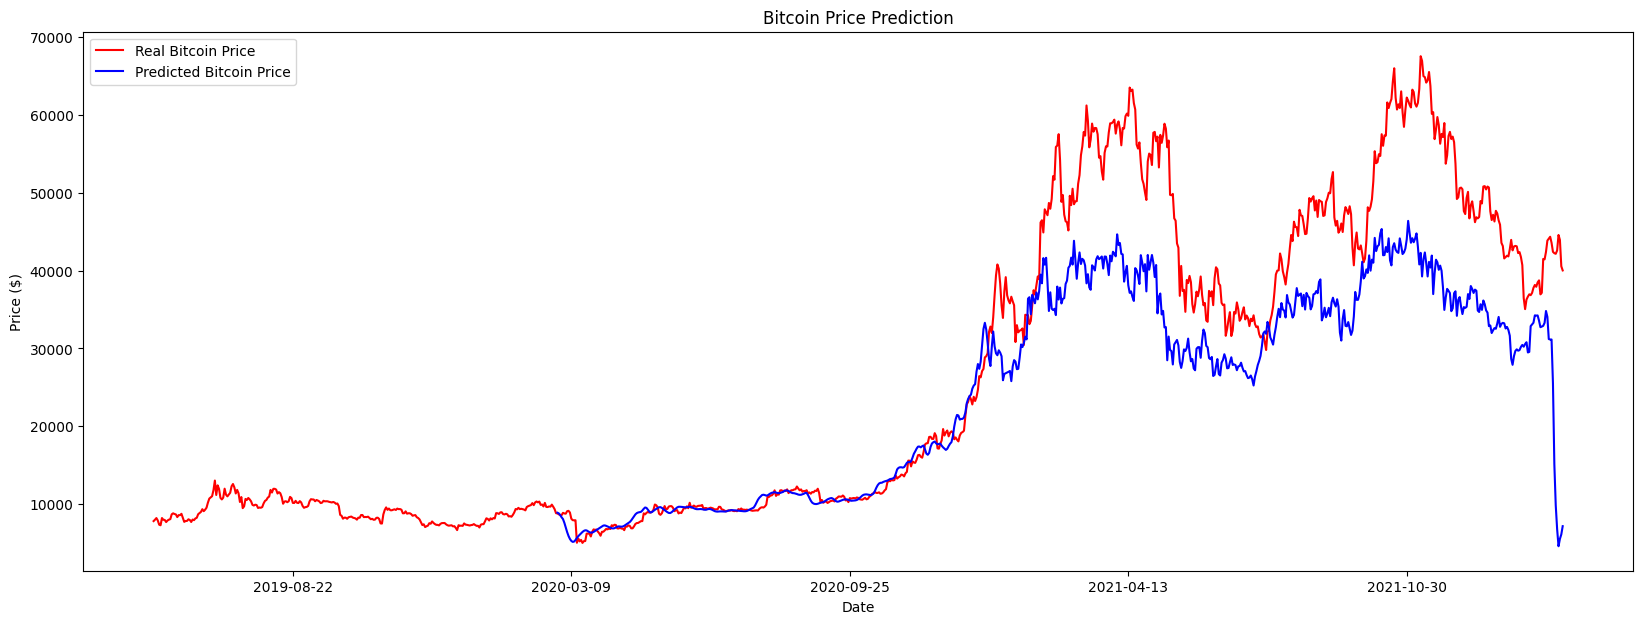

In [39]:
plt.figure(figsize=(20,7))
plt.plot(df['Date'].values[1700:], df_volume[1700:], color = 'red', label = 'Real Bitcoin Price')
plt.plot(df['Date'][-prediction_full_new.shape[0]:].values, prediction_full_new, color = 'blue', label = 'Predicted Bitcoin Price')
plt.xticks(np.arange(100,df[1700:].shape[0],200))
plt.title('Bitcoin Price Prediction')
plt.xlabel('Date')
plt.ylabel('Price ($)')
plt.legend()
plt.show()

In [40]:
# The GRU architecture
modelGRU = Sequential()

modelGRU.add(GRU(units=50, return_sequences=True, input_shape=(X_train.shape[1],1)))
modelGRU.add(Dropout(0.2))

modelGRU.add(GRU(units=50, return_sequences=True, input_shape=(X_train.shape[1],1)))
modelGRU.add(Dropout(0.2))

modelGRU.add(GRU(units=50, return_sequences=True, input_shape=(X_train.shape[1],1)))
modelGRU.add(Dropout(0.2))

modelGRU.add(GRU(units=50))
modelGRU.add(Dropout(0.2))

modelGRU.add(Dense(units=1))
modelGRU.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru (GRU)                   (None, 60, 50)            7950      
                                                                 
 dropout_4 (Dropout)         (None, 60, 50)            0         
                                                                 
 gru_1 (GRU)                 (None, 60, 50)            15300     
                                                                 
 dropout_5 (Dropout)         (None, 60, 50)            0         
                                                                 
 gru_2 (GRU)                 (None, 60, 50)            15300     
                                                                 
 dropout_6 (Dropout)         (None, 60, 50)            0         
                                                                 
 gru_3 (GRU)                 (None, 50)               

In [41]:
modelGRU.compile(optimizer='adam', loss='mean_squared_error')
modelGRU.fit(X_train, y_train, epochs=100, batch_size=128)

Epoch 1/100
16/16 [==============================] - 22s 389ms/step - loss: 0.0264
Epoch 2/100
16/16 [==============================] - 6s 348ms/step - loss: 0.0041
Epoch 3/100
16/16 [==============================] - 6s 348ms/step - loss: 0.0028
Epoch 4/100
16/16 [==============================] - 6s 368ms/step - loss: 0.0020
Epoch 5/100
16/16 [==============================] - 7s 421ms/step - loss: 0.0021
Epoch 6/100
16/16 [==============================] - 8s 489ms/step - loss: 0.0019
Epoch 7/100
16/16 [==============================] - 9s 550ms/step - loss: 0.0018
Epoch 8/100
16/16 [==============================] - 6s 402ms/step - loss: 0.0018
Epoch 9/100
16/16 [==============================] - 7s 432ms/step - loss: 0.0017
Epoch 10/100
16/16 [==============================] - 6s 399ms/step - loss: 0.0016
Epoch 11/100
16/16 [==============================] - 6s 376ms/step - loss: 0.0015
Epoch 12/100
16/16 [==============================] - 6s 392ms/step - loss: 0.0016
Epoch 13/100

In [43]:
predict = modelGRU.predict(X_test)
predict = sc.inverse_transform(predict)
predict

23/23 [==============================] - 1s 49ms/step


array([[ 9163.41  ],
       [ 8656.129 ],
       [ 8309.717 ],
       [ 8194.977 ],
       [ 8171.752 ],
       [ 6686.5957],
       [ 5999.6475],
       [ 5677.4814],
       [ 5622.173 ],
       [ 5430.486 ],
       [ 5379.844 ],
       [ 5380.7495],
       [ 5832.108 ],
       [ 6133.327 ],
       [ 6219.764 ],
       [ 6060.443 ],
       [ 6257.785 ],
       [ 6586.084 ],
       [ 6717.648 ],
       [ 6771.728 ],
       [ 6670.2007],
       [ 6497.3765],
       [ 6256.7856],
       [ 6385.6216],
       [ 6516.156 ],
       [ 6646.334 ],
       [ 6802.7275],
       [ 6848.0874],
       [ 6917.6724],
       [ 6922.445 ],
       [ 7172.841 ],
       [ 7277.5015],
       [ 7382.161 ],
       [ 7419.609 ],
       [ 7202.27  ],
       [ 7070.319 ],
       [ 7091.875 ],
       [ 7058.861 ],
       [ 7029.1523],
       [ 6909.614 ],
       [ 7085.7676],
       [ 7199.4243],
       [ 7317.4185],
       [ 7332.819 ],
       [ 7165.697 ],
       [ 7070.351 ],
       [ 7173.799 ],
       [ 7415

In [46]:
iff = predict - test

print("MSE:", np.mean(iff**2))
print("MAE:", np.mean(abs(iff)))
print("RMSE:", np.sqrt(np.mean(iff**2)))

MSE: 18616097.09256759
MAE: 2927.0895801512092
RMSE: 4314.637538955919


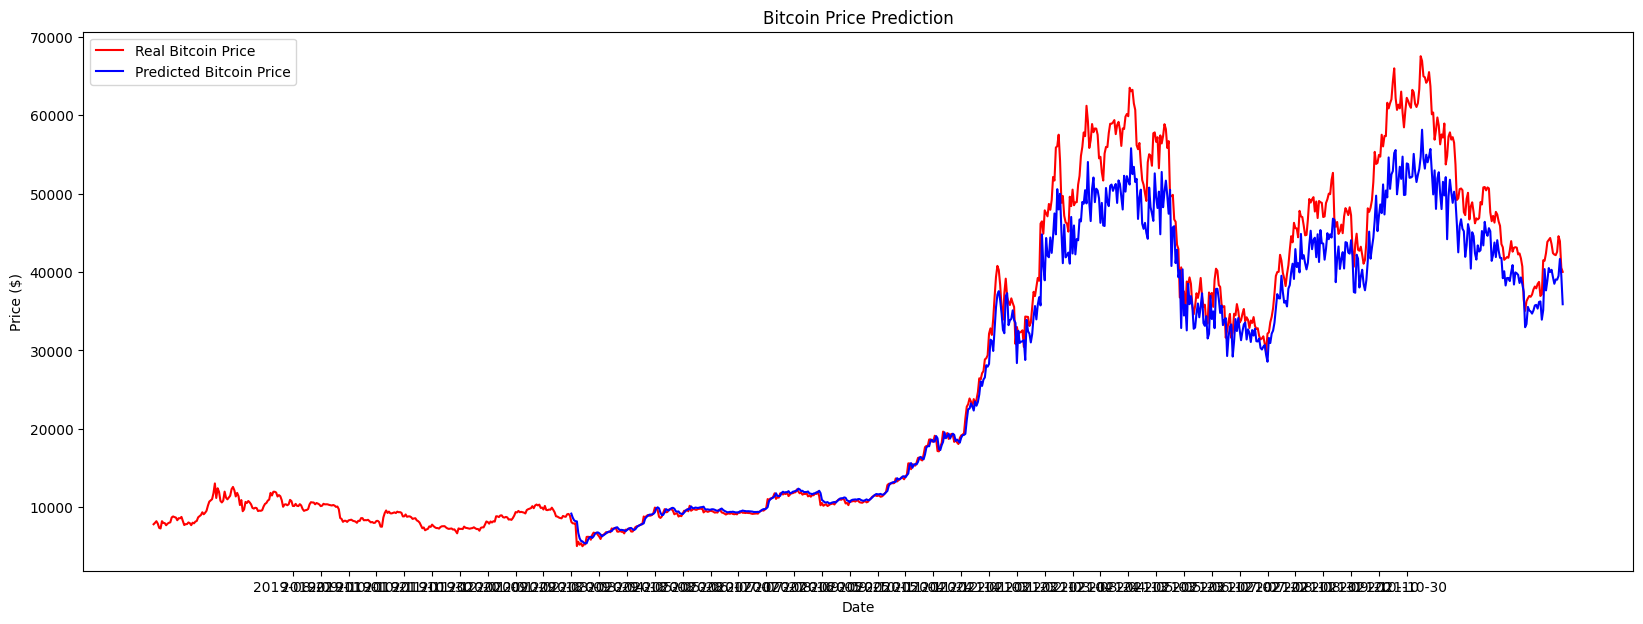

In [47]:
plt.figure(figsize=(20,7))
plt.plot(df['Date'].values[1700:], df_volume[1700:], color = 'red', label = 'Real Bitcoin Price')
plt.plot(df['Date'][-predict.shape[0]:].values, predict, color = 'blue', label = 'Predicted Bitcoin Price')
plt.xticks(np.arange(100,df[1800:].shape[0],20))
plt.title('Bitcoin Price Prediction')
plt.xlabel('Date')
plt.ylabel('Price ($)')
plt.legend()
plt.show()

In [48]:
pred_ = predict[-1].copy()
prediction_full = []
window = 60
df_copy = df.iloc[:, 1:2][1:].values

for j in range(20):
    df_ = np.vstack((df_copy, pred_))
    train_ = df_[:num_shape]
    test_ = df_[num_shape:]
    
    df_volume_ = np.vstack((train_, test_))

    inputs_ = df_volume_[df_volume_.shape[0] - test_.shape[0] - window:]
    inputs_ = inputs_.reshape(-1,1)
    inputs_ = sc.transform(inputs_)

    X_test_2 = []

    for k in range(window, num_2):
        X_test_3 = np.reshape(inputs_[k-window:k, 0], (window, 1))
        X_test_2.append(X_test_3)

    X_test_ = np.stack(X_test_2)
    predict_ = modelGRU.predict(X_test_)
    pred_ = sc.inverse_transform(predict_)
    prediction_full.append(pred_[-1][0])
    df_copy = df_[j:]

23/23 [==============================] - 1s 53ms/step


In [50]:
prediction_full_new = np.vstack((predict, np.array(prediction_full).reshape(-1,1)))

df_date = df[['Date']]

for h in range(20):
    kk = pd.to_datetime(df_date['Date'].iloc[-1]) + pd.DateOffset(days=1)
    kk = pd.DataFrame([kk.strftime("%Y-%m-%d")], columns=['Date'])
    df_date = df_date.append(kk)
df_date = df_date.reset_index(drop=True)

C:\Users\pc\AppData\Local\Temp\ipykernel_13832\624679361.py:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_date = df_date.append(kk)
C:\Users\pc\AppData\Local\Temp\ipykernel_13832\624679361.py:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_date = df_date.append(kk)
C:\Users\pc\AppData\Local\Temp\ipykernel_13832\624679361.py:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_date = df_date.append(kk)
C:\Users\pc\AppData\Local\Temp\ipykernel_13832\624679361.py:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_date = df_date.append(kk)
C:\Users\pc\AppData\Local\Temp\ipykernel_13832\624679361.py:8: FutureWarning: The frame.appe

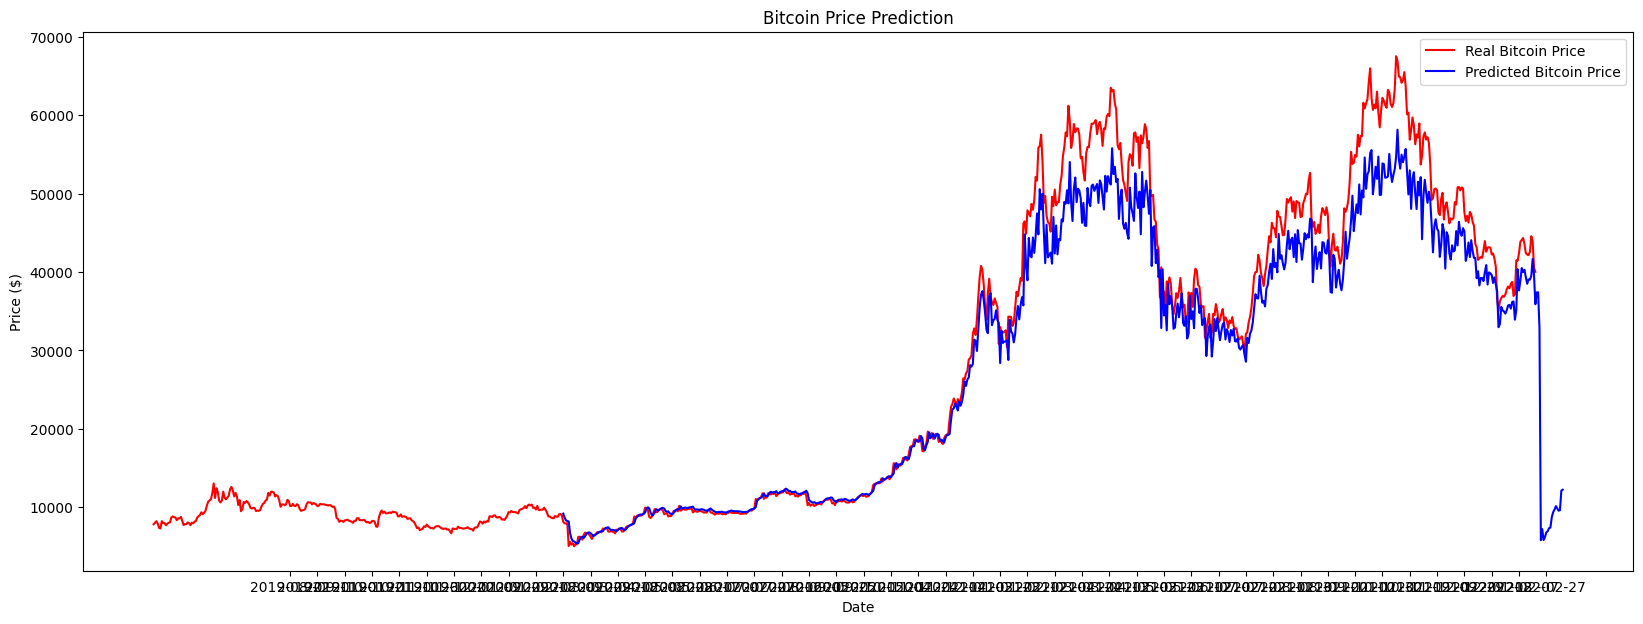

In [51]:
plt.figure(figsize=(20,7))
plt.plot(df['Date'].values[1700:], df_volume[1700:], color = 'red', label = 'Real Bitcoin Price')
plt.plot(df_date['Date'][-prediction_full_new.shape[0]:].values, prediction_full_new, color = 'blue', label = 'Predicted Bitcoin Price')
plt.xticks(np.arange(100,df_date[1700:].shape[0],20))
plt.title('Bitcoin Price Prediction')
plt.xlabel('Date')
plt.ylabel('Price ($)')
plt.legend()
plt.show()